In [1]:
using Distributions 
using IntervalSets
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Random123
using HCubature

using KDTree
using BAT
using BATPar

using LaTeXStrings

In [2]:
import PyPlot
# import Plots
# Plots.pyplot()

plt = PyPlot

SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = vcat([0 0 0 0], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:])

include("plotting recipes.jl");

# Density Function

## Density 1:

In [40]:
# Multimodal Caushy pdf: 

true_param =(μ1=2, μ2=-2, σ=0.13)

function f(x::AbstractArray; true_param=true_param)
    tmp = 1
    for i in eachindex(x)
        if i > 2
            tmp *= pdf(Cauchy(true_param.μ1 + true_param.μ2, true_param.σ), x[i])
        else 
            tmp *= 0.5*pdf(Cauchy(true_param.μ1, true_param.σ), x[i]) + 0.5*pdf(Cauchy(true_param.μ2, true_param.σ), x[i])
        end
    end
    return tmp
end

function LogTrueIntegral(N; max = max_v, min=min_v,  true_param=true_param) 
    tmp = 0
    for i in 1:N
        if i > 2
            tmp += log(cdf(Cauchy(true_param.μ1 + true_param.μ2,true_param.σ), max_v) - cdf(Cauchy(true_param.μ1 + true_param.μ2,true_param.σ), min_v))
        else 
            tmp += log(cdf(Cauchy(true_param.μ1,true_param.σ), max_v) - cdf(Cauchy(true_param.μ1 ,true_param.σ), min_v))
        end
    end
    return tmp
end

N = 10
min_v = -5.
max_v = 5.
lgV = N*log(max_v-min_v); 

## Density 2:

In [ ]:
# simple Normal Distribution: 

N = 4
min_v = -10.
max_v = 10.

lgV = N*log(max_v-min_v); 

f(x::AbstractArray) = prod(pdf.(Normal(0, 1), x))

LogTrueIntegral(N)=0.0

## Density 2:

In [ ]:
# Funnel: 

density_type = Normal(0.0, 1.0)

function f(x::Array{Float64}; density_type=density_type)
    b=1
    μ = 0.0
    σ = 1.0
    return pdf(Normal(μ, σ), x[1])*prod(pdf.(Normal(μ, exp(2*b*x[1])), x[2:end]))   
end

N = 4
min_v = -30.
max_v = 30.

lgV = N*log(max_v-min_v); 

LogTrueIntegral(N)=0.0

# Serial Sampling

In [41]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.65..0.75,
    β = 1.5,
    c = 1e-4..1e4
)


# * `λ`: Controls the weight given to new covariance information in adapting
#   the proposal distribution. Defaults to `0.5`.

# * `α`: Metropolis-Hastings acceptance ratio target, tuning will try to
#   adapt the proposal distribution to bring the acceptance ratio inside this
#   interval. Defaults to `IntervalSets.ClosedInterval(0.15, 0.35)`

# * `β`: Controls how much the spread of the proposal distribution is
#   widened/narrowed depending on the current MH acceptance ratio.

# * `c`: Interval for allowed scale/spread of the proposal distribution.
#   Defaults to `ClosedInterval(1e-4, 1e2)`.

# * `r`: Reweighting factor. Take accumulated sample statistics of previous
#   tuning cycles into account with a relative weight of `r`. Set to `0` to
#   completely reset sample statistics between each tuning cycle.


convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 20..1000,
    max_nsamples_init = 1000,
    max_nsteps_init = 1000,
    max_time_init = 18
)

# `init_tries_per_chain`: Interval that specifies the minimum and maximum
#   number of tries per MCMC chain to find a suitable starting position. Many
#   candidate chains will be created and run for a short time. The chains with
#   the best performance will be selected for tuning/burn-in and MCMC sampling
#   run. Defaults to `IntervalSets.ClosedInterval(8, 128)`.

# * `max_nsamples_init`: Maximum number of MCMC samples for each candidate
#   chain. Defaults to 25. Definition of a sample depends on sampling algorithm.

# * `max_nsteps_init`: Maximum number of MCMC steps for each candidate chain.
#   Defaults to 250. Definition of a step depends on sampling algorithm.

# * `max_time_init::Int`: Maximum wall-clock time to spend per candidate chain,
#   in seconds. Defaults to `Inf`.

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = 25,
    max_ncycles = 0
)

# * `max_nsamples_per_cycle`: Maximum number of MCMC samples to generate per
#   cycle, defaults to `1000`. Definition of a sample depends on MCMC algorithm.

# * `max_nsteps_per_cycle`: Maximum number of MCMC steps per cycle, defaults
#   to `10000`. Definition of a step depends on MCMC algorithm.

# * `max_time_per_cycle`: Maximum wall-clock time to spend per cycle, in
#   seconds. Defaults to `Inf`.

# * `max_ncycles`: Maximum number of cycles.



MCMCBurninStrategy
  max_nsamples_per_cycle: Int64 4000
  max_nsteps_per_cycle: Int64 4000
  max_time_per_cycle: Float64 25.0
  max_ncycles: Int64 0


In [42]:
likelihood = params -> LogDVal((log(f(params.a))))
prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],)
posterior = PosteriorDensity(likelihood, prior);

## Serial MCMC over whole parameter space:

In [43]:
samples_serial, stats_serial = bat_sample(posterior, (10^5, 5), MetropolisHastings()); #tuning=tuning, init=init, burnin=burnin

┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 4 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:

## Exploration samples: 

In [44]:
nnsamples = 10^2
nnchains = 50

samples, stats = bat_sample(posterior, (nnsamples, nnchains), MetropolisHastings(), burnin=burnin);

┌ Info: Trying to generate 50 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 50 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 50 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Warning: MCMC tuning of 50 chains aborted after 0 cycle(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:108


In [45]:
smpl = collect(flatview(unshaped.(samples.v)))
weights_LogLik = samples.logd
weights_Histogram = samples.weight;

data_kdtree = Data(smpl[:,1:end], weights_Histogram[1:end], weights_LogLik[1:end]);

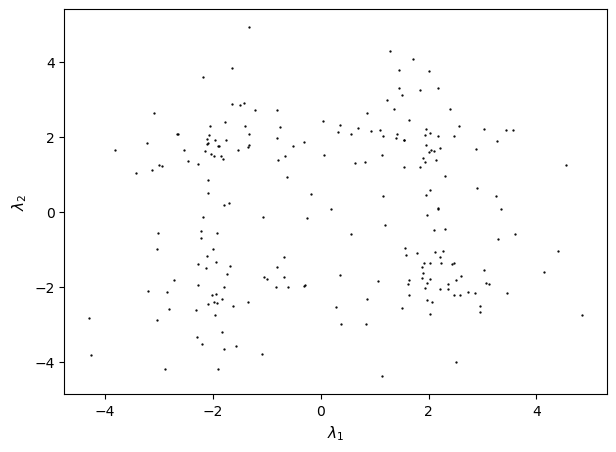

PyObject Text(28.70000000000001, 0.5, '$\\lambda_2$')

In [46]:
# x_range = range(min_v, stop=max_v, length=100)
# y_range = range(min_v, stop=max_v, length=100)

# z = [f([i,j]) for i in x_range, j in y_range]';

# levels_quantiles = [0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.95, 0.99, 1,]
# levels=quantile([z...], levels_quantiles)

# colors = vcat([1 1 1 1], plt.cm.Blues(range(0, stop=1, length=length(levels_quantiles)))[2:end,:])

fig, ax = plt.subplots(1,1, figsize=(7, 5))
# ax.contourf(x_range, y_range, z, levels=levels, colors=colors, alpha=0.5)
ax.scatter(smpl[1,:], smpl[2,:], color="k", s=0.4)

# ax.set_yticks([])
# ax.set_xticks([])
 
ax.set_xlabel(L"\lambda_1")
ax.set_ylabel(L"\lambda_2")

# Space Partitioning: 

In [47]:
KDTree.evaluate_total_cost(data::Data) = KDTree.cost_f_1(data)

output, cost_array = DefineKDTree(data_kdtree, [1,2,3,4,5,6,7,8], 6);

extend_tree_bounds!(output, repeat([min_v], N), repeat([max_v], N))

┌ Info: KDTree: Increasing tree depth: depth = 1
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 2
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 3
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 4
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 5
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 6
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183


In [48]:
prior_bounds = [min_v, max_v] 

extend_tree_bounds!(output, repeat([prior_bounds[1]], N), repeat([prior_bounds[2]], N))

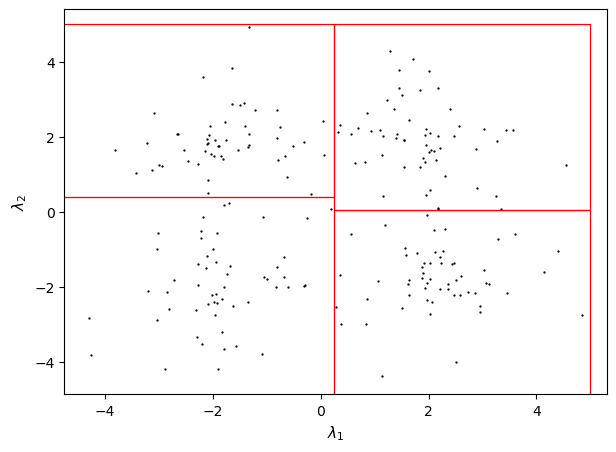

PyObject <matplotlib.patches.Rectangle object at 0x19bb423d0>

In [49]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
# ax.contourf(x_range, y_range, z, levels=levels, colors=colors, alpha=0.5)
ax.scatter(smpl[1,:], smpl[2,:], color="k", s=0.4)

# ax.set_yticks([])
# ax.set_xticks([])
 
ax.set_xlabel(L"\lambda_1")
ax.set_ylabel(L"\lambda_2")

plot_tree(output, [1,2], ax, color="red")

# ax.set_xlim(-11., 11.)
# ax.set_ylim(-11., 11.)

# ax.set_xlim(-4., 4.)
# ax.set_ylim(-4., 4.)

# Sampling of subspaces 

In [50]:
bounds_part = extract_par_bounds(output)

BATPar.make_named_prior(i) = BAT.NamedTupleDist( a =  [[i[j,1]..i[j,2] for j in 1:size(i)[1]]...])

nnsamples = 10^5
nnchains = 4

# tuning = AdaptiveMetropolisTuning(
#     λ = 0.5,
#     α = 0.15..0.45,
#     β = 1.5,
#     c = 1e-4..1e2
# )

# init = MCMCInitStrategy(
#     init_tries_per_chain = 20..200000,
#     max_nsamples_init = 30000,
#     max_nsteps_init = 10000,
#     max_time_init = 200
# )

algorithm = MetropolisHastings();

samples_parallel = bat_sample_parallel(likelihood, bounds_part, (nnsamples, nnchains), algorithm, ); #tuning=tuning, init=init

┌ Info: BATPar: Sampling subspace 1:
└ @ BATPar /Users/vhafych/MPP-Server/gitrepos/BATPar.jl/src/BATPar.jl:82
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 4 finished, 4 ch

In [51]:
smpl_par = hcat(samples_parallel.samples...)
x = smpl_par[1,:]
y = smpl_par[2,:]
w_o = samples_parallel.weights_o
w_r =  samples_parallel.weights_r;

In [52]:
@show "Truth", exp(LogTrueIntegral(N))

@show "Int", sum(w_r), sqrt(sum((samples_parallel.uncertainty).^2));

("Truth", exp(LogTrueIntegral(N))) = ("Truth", 0.8409029746006453)
("Int", sum(w_r), sqrt(sum(samples_parallel.uncertainty .^ 2))) = ("Int", 0.8511080733001617, 0.0057501901986044286)


In [53]:
# Tuning improvenment: 

# tun_cycles = [4,4,5,6,10, 10, 10, 9, 11, 8, 6,4,5,4,7,5]

# fig, ax = plt.subplots(1,1, figsize=(5, 4))

# ax.hist(tun_cycles, bins=1:1:30, color="C0", label="w/ space partitioning")
# ax.vlines([28], 0, 5, color="red", alpha=0.5, ls="--", label="w/o space partitioning")

# ax.set_xlabel("# tunning cycles")
# ax.set_ylabel("counts")

# ax.set_yticks(collect(1:1:4))

# ax.set_xlim(0., 30.)
# ax.set_ylim(0., 4.5)

# ax.legend(loc="upper center", frameon=true, framealpha=0.9, ncol=1)

# # fig.savefig("../../MCMC_publication/fig-i.pdf", bbox_inches = "tight")

#### 2D histogram:

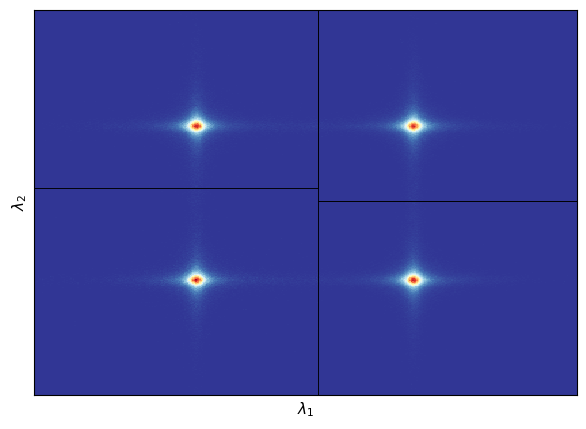

PyObject <matplotlib.patches.Rectangle object at 0x19a4e7e10>

In [54]:
colors_m = vcat([1 1 1 1], plt.cm.Blues(range(0, stop=1, length=10))[2:end,:])

tmp = PyPlot.ColorMap(colors_m)

fig, ax = plt.subplots(1,1, figsize=(7, 5))

ax.hist2d(x, y, weights=w_r, bins=400,  cmap="RdYlBu_r")

ax.set_yticks([])
ax.set_xticks([])
 
ax.set_xlabel(L"\lambda_1")
ax.set_ylabel(L"\lambda_2")

plot_tree(output, [1,2], ax, linewidth=0.4, color="black", alpha=1)

# ax.set_xlim(-5., 5.)
# ax.set_ylim(-5., 5.)

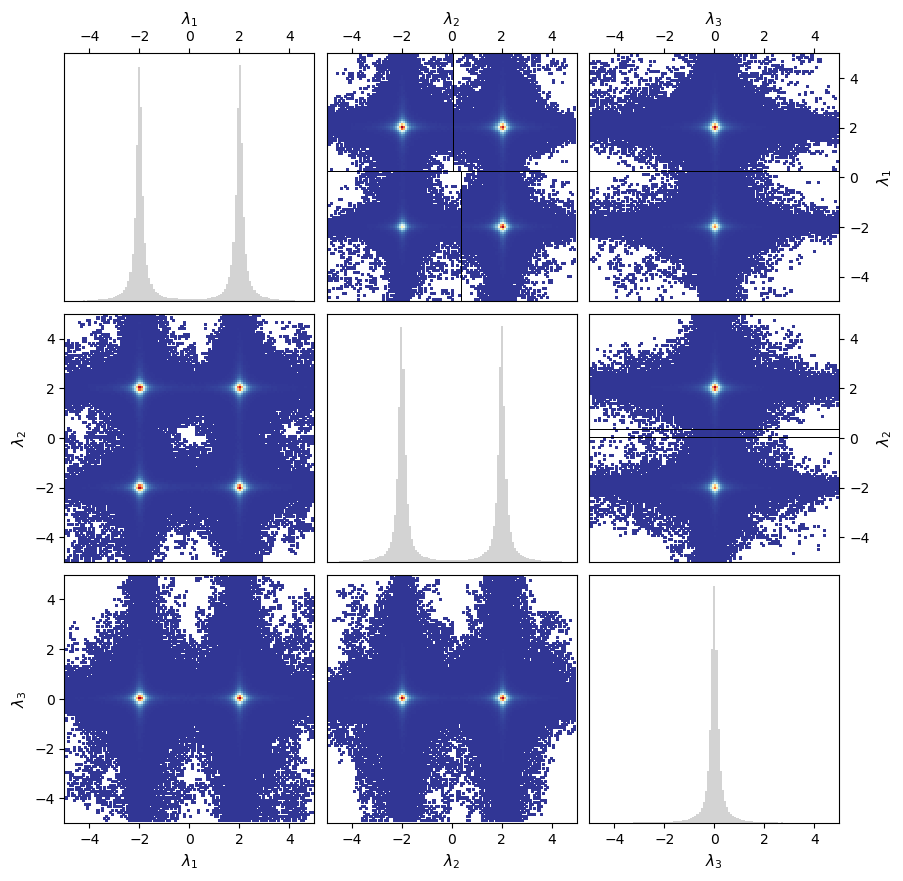

In [55]:
corner_plots(smpl_par, output, w_r, w_o, 
    [1,2,3], [L"\lambda_1", L"\lambda_2", L"\lambda_3", L"\lambda_4",  L"\lambda_5"], 
    N_bins=120, linewidth=0.6, color="black",
    save_plot=false,
    FILE_NAME = "../../MCMC_publication/fig-f-2-a.png",
    )

## Comparison Plots Parallel vs. Serial: 

In [56]:
smpl_serial = flatview(unshaped.(samples_serial.v))
weights_LogLik_serial = samples_serial.logd
weights_Histogram_serial = samples_serial.weight;

In [57]:
bin_range = range(-5, stop=5, length=50)

histogram_wo = fit(Histogram, (smpl_serial[1,:], smpl_serial[2,:]), weights(weights_Histogram_serial), (bin_range, bin_range))
histogram_wo = normalize(histogram_wo, mode=:pdf)

histogram_wr = fit(Histogram, (x, y), weights(w_r), (bin_range,bin_range))
histogram_wr = normalize(histogram_wr, mode=:pdf);

In [58]:
z = histogram_wo.weights;

levels_quantiles = [ 0.45, 0.92, 0.981, 0.988, 0.99, 0.999, 1,]
levels=quantile([z...], levels_quantiles);

In [59]:
# levels=range(0.03855375566406406, maximum(z), length=6)

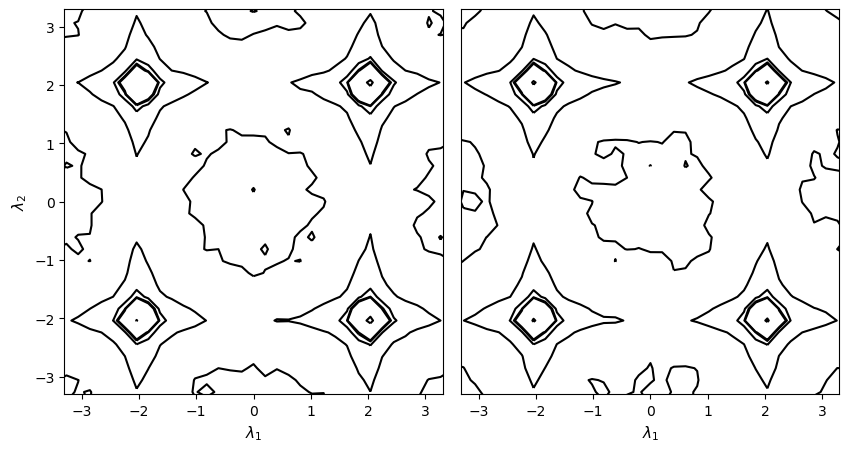

(-3.3, 3.3)

In [60]:

fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.05)

ax[1].contour(midpoints(histogram_wo.edges[1]), midpoints(histogram_wo.edges[2]), replace(histogram_wo.weights', 0=>NaN), colors="black", levels=levels) 
ax[2].contour(midpoints(histogram_wr.edges[1]), midpoints(histogram_wr.edges[2]), replace(histogram_wr.weights', 0=>NaN), colors="k", levels=levels) 

# ax[1].contourf(midpoints(histogram_wo.edges[1]), midpoints(histogram_wo.edges[2]), replace(histogram_wo.weights', 0=>NaN), cmap="RdYlBu_r", levels=levels) 
# ax[2].contourf(midpoints(histogram_wr.edges[1]), midpoints(histogram_wr.edges[2]), replace(histogram_wr.weights', 0=>NaN), cmap="RdYlBu_r", levels=levels) 
 
ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"\lambda_2")

ax[2].set_xlabel(L"\lambda_1")
ax[2].get_yaxis().set_visible(false) 

ax[1].set_xlim(-3.3, 3.3)
ax[1].set_ylim(-3.3, 3.3)
ax[2].set_xlim(-3.3, 3.3)
ax[2].set_ylim(-3.3, 3.3)

# fig.savefig("../../MCMC_publication/fig-h.pdf", bbox_inches = "tight")

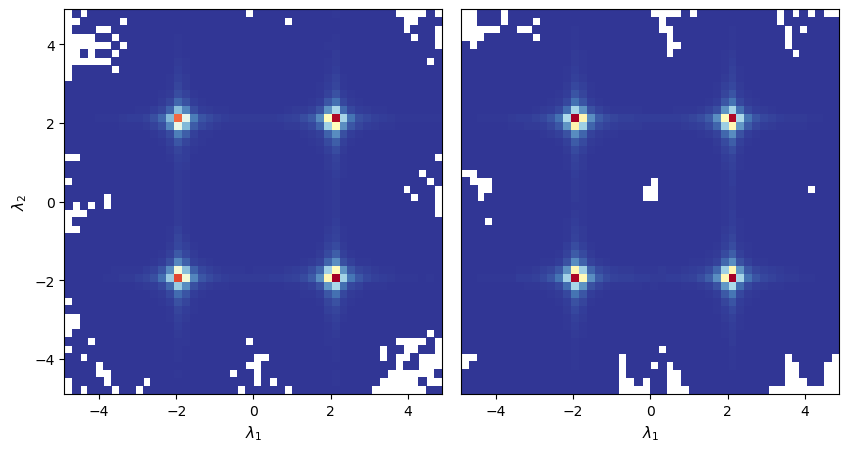

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.05)

ax[1].pcolormesh(midpoints(histogram_wo.edges[1]), midpoints(histogram_wo.edges[2]), replace(histogram_wo.weights', 0=>NaN), cmap="RdYlBu_r") 

ax[2].pcolormesh(midpoints(histogram_wr.edges[1]), midpoints(histogram_wr.edges[2]), replace(histogram_wr.weights', 0=>NaN), cmap="RdYlBu_r") 
 
ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"\lambda_2")

ax[2].set_xlabel(L"\lambda_1")
ax[2].get_yaxis().set_visible(false) 


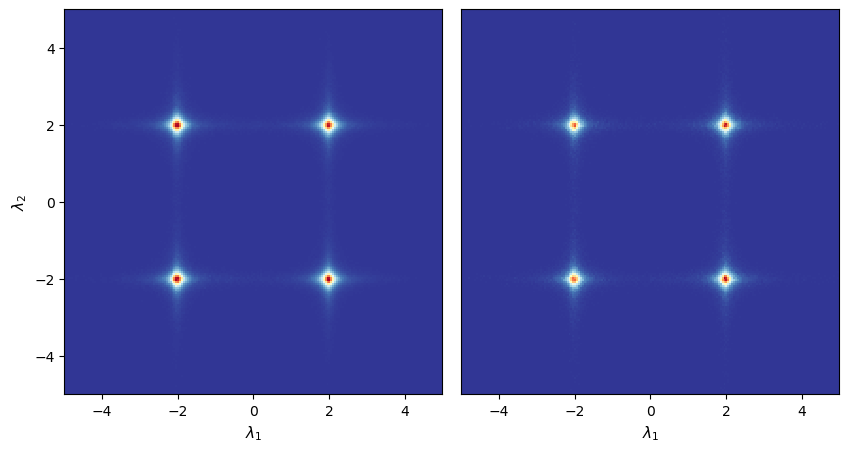

In [63]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.05)

ax[1].hist2d(x, y, weights=w_r, bins=200,  cmap="RdYlBu_r")

ax[2].hist2d(smpl_serial[1,:], smpl_serial[2,:], weights=weights_Histogram_serial, bins=200,  cmap="RdYlBu_r")
 
ax[1].set_xlabel(L"\lambda_1")
ax[1].set_ylabel(L"\lambda_2")

ax[2].set_xlabel(L"\lambda_1")
ax[2].get_yaxis().set_visible(false) 
